# Basic Image Composition with PIL
The following code will compose images together randomly to generate a new synthetic dataset of images.

**IMPORTANT:**
- Foregrounds should be .png format, each with a single isolated object and transparent background.
- Backgrounds may be .jpg or .png format and should be larger than the foregrounds.

--------------------------------------------
Requirements:
- Python 3
- Jupyter Notebook (http://jupyter.readthedocs.io/en/latest/install.html)
- Pillow (pip install pillow)
- numpy (pip install numpy)

Notes:
- This code does not downsample large images. It is recommended that you consider how large your images should be and either account for this in code or provide the correct resolution in your image directories ahead of time
- Examples are given for rotation and scaling, but you could also change brightness, perspective, blur, etc.
- Basic assert statements are included to help with simple errors, but they are not exhaustive

In [1]:
import os
import random
import numpy as np
import errno
import csv
from PIL import Image

## compose_images()
- Takes in a foreground image path and a background image path
- Randomly rotates and scales the foreground
- Pastes the foreground on the background
- Creates a bit-mask image
- Calculates a bounding box
- Returns the image, mask, and bounding box

In [6]:
def compose_images(foreground_path, background_path):
    # Make sure the foreground path is valid and open the image
    assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
    foreground = Image.open(foreground_path)
    foreground_alpha = np.array(foreground.getchannel(3))
    assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
    assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
    assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', '.jpeg'], \
        'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    background = Image.open(background_path)
    background = background.convert('RGBA')
    
    # Rotate the foreground
    angle_degrees = random.randint(0, 359)
    foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
    # Scale the foreground
    scale = random.random() * .5 + .5 # Pick something between .5 and 1
    new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
    foreground = foreground.resize(new_size, resample=Image.BICUBIC)
    
    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))
    
    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
        
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    alpha_mask = foreground.getchannel(3)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])] 

    return composite, hard_mask, bbox

## Generate Images
- Get the image paths
- Create an output directory
- Generate new images
- Create a .csv definition file for the annotations

In [7]:
# Get lists of foreground and background image paths
dataset_dir = '../IMGS/synthetic_dataset'
backgrounds_dir = os.path.join(dataset_dir, 'backgrounds', 'JPG')
foregrounds_dir = os.path.join(dataset_dir, 'foregrounds', 'JPG')
backgrounds = [os.path.join(backgrounds_dir, file_name) for file_name in os.listdir(backgrounds_dir)]
foregrounds = [os.path.join(foregrounds_dir, file_name) for file_name in os.listdir(foregrounds_dir)]

# Create an output directory
output_dir = os.path.join(dataset_dir, 'generated')
try:
    os.mkdir(output_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Create a list to keep track of images and mask annotations
csv_lines = []

# Generate 5 new images
for i in range(2):
    foreground_path = random.choice(foregrounds)
    background_path = random.choice(backgrounds)
    composite, mask, bbox = compose_images(foreground_path, background_path)
    
    composite_path = os.path.join(output_dir, 'image_{0:04d}.tif'.format(i))
    composite.save(composite_path)
    
    mask_path = os.path.join(output_dir, 'mask_{0:04d}.tif'.format(i))
    mask.save(mask_path)
    
    csv_lines.append([composite_path, bbox, mask_path])
    
# Output the annotations csv
annotations_csv_path = os.path.join(output_dir, 'annotations.csv')
with open(annotations_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for csv_line in csv_lines:
        writer.writerow(csv_line)
    

AssertionError: foreground must be a .png or .jpg file: ../IMGS/synthetic_dataset/foregrounds/copa_1108.tif

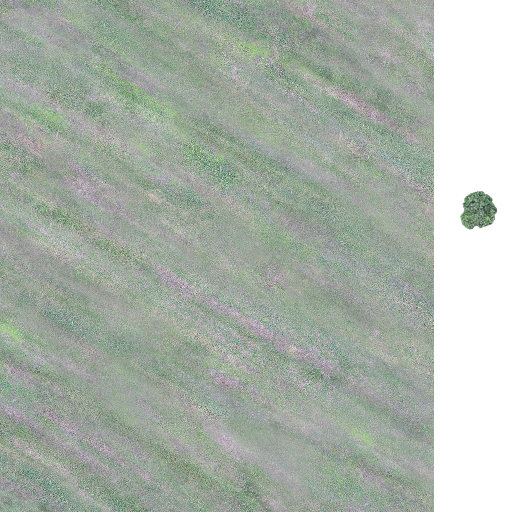

In [4]:
sample_image_path = csv_lines[0][0]
sample_image = Image.open(sample_image_path)
sample_image

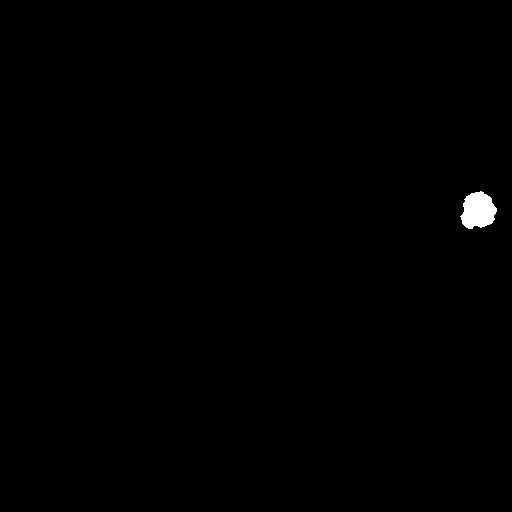

In [5]:
sample_mask_path = csv_lines[0][2]
sample_mask = Image.open(sample_mask_path)
sample_mask